<a href="https://colab.research.google.com/github/Aras1703/Credit_risk_modelling/blob/main/Credit_risk_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORT DEPENDENCIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import classification_report, plot_confusion_matrix
import tensorflow as tf
from keras import regularizers

In [ ]:
DATA_LOAN = '/content/app_train.csv'
DATA_TRAIN = pd.read_csv(DATA_LOAN)
DATA_TRAIN.head()

,Unnamed: 0,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,...,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3
0,201468,333538,0,Revolving loans,F,1,67500.0,202500.0,10125.0,202500.0,...,-11539,-921,-119.0,-2757,TUESDAY,18,Business Entity Type 3,0.572805,0.608276,NaN
1,264803,406644,0,Cash loans,F,1,202500.0,976711.5,49869.0,873000.0,...,-15743,-4482,-1797.0,-2455,TUESDAY,14,Other,0.655600,0.684298,NaN
2,137208,259130,0,Cash loans,F,0,180000.0,407520.0,25060.5,360000.0,...,-20775,365243,-8737.0,-4312,THURSDAY,14,NA1,NaN,0.580687,0.749022
3,269220,411997,0,Cash loans,M,0,225000.0,808650.0,26086.5,675000.0,...,-20659,-10455,-4998.0,-4010,WEDNESDAY,10,Culture,NaN,0.623740,0.710674
4,122096,241559,0,Revolving loans,M,0,135000.0,180000.0,9000.0,180000.0,...,-9013,-1190,-3524.0,-1644,SUNDAY,11,Construction,0.175511,0.492994,0.085595


## EDA

Analysis Explanation: 
1. I guess "Unnamed: 0" column is not used in the data so i drop this column, "LN_ID" is a unique column so i did the same thing as before and EXT_SCORE is a normalized column, i guess we don't need them too. I checked the nan values in every columns.
2. Before plotting the correlated data, the object data in every column must be change into int or float dtype. I did a preprocess for a categorical columns using label encoder.
3. From the correlation plot i assume that the "APPROVE CREDIT", "ANNUITY", and "PRICE" column is correlating with each other, however the "NUM_CHILDREN" and "DAYS_AGE" column can also be used as feature selection even though the correlation between the data are low.
4. From the process that has been done before, i took 5 feature + made 3 feature engineering to get into the model and i did some feature engineering for "DAYS_AGE" column that has low correlated data.

### CHECK INFO AND NAN DATA

note : i drop the feature that won't be used in the data and checking nan values in every column

In [ ]:
DATA_TRAIN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61503 entries, 0 to 61502
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         61503 non-null  int64  
 1   LN_ID              61503 non-null  int64  
 2   TARGET             61503 non-null  int64  
 3   CONTRACT_TYPE      61503 non-null  object 
 4   GENDER             61503 non-null  object 
 5   NUM_CHILDREN       61503 non-null  int64  
 6   INCOME             61503 non-null  float64
 7   APPROVED_CREDIT    61503 non-null  float64
 8   ANNUITY            61502 non-null  float64
 9   PRICE              61441 non-null  float64
 10  INCOME_TYPE        61503 non-null  object 
 11  EDUCATION          61503 non-null  object 
 12  FAMILY_STATUS      61503 non-null  object 
 13  HOUSING_TYPE       61503 non-null  object 
 14  DAYS_AGE           61503 non-null  int64  
 15  DAYS_WORK          61503 non-null  int64  
 16  DAYS_REGISTRATION  615

In [ ]:
DATA_TRAIN.isnull().sum()

Unnamed: 0               0
LN_ID                    0
TARGET                   0
CONTRACT_TYPE            0
GENDER                   0
NUM_CHILDREN             0
INCOME                   0
APPROVED_CREDIT          0
ANNUITY                  1
PRICE                   62
INCOME_TYPE              0
EDUCATION                0
FAMILY_STATUS            0
HOUSING_TYPE             0
DAYS_AGE                 0
DAYS_WORK                0
DAYS_REGISTRATION        0
DAYS_ID_CHANGE           0
WEEKDAYS_APPLY           0
HOUR_APPLY               0
ORGANIZATION_TYPE        0
EXT_SCORE_1          34845
EXT_SCORE_2            134
EXT_SCORE_3          12239
dtype: int64

In [ ]:
DATA_TRAIN = DATA_TRAIN.drop(columns=['Unnamed: 0', 'LN_ID', 'EXT_SCORE_1', 'EXT_SCORE_2', 'EXT_SCORE_3'], axis=1,)
DATA_TRAIN.head()

,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE
0,0,Revolving loans,F,1,67500.0,202500.0,10125.0,202500.0,Working,Secondary / secondary special,Married,With parents,-11539,-921,-119.0,-2757,TUESDAY,18,Business Entity Type 3
1,0,Cash loans,F,1,202500.0,976711.5,49869.0,873000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15743,-4482,-1797.0,-2455,TUESDAY,14,Other
2,0,Cash loans,F,0,180000.0,407520.0,25060.5,360000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-20775,365243,-8737.0,-4312,THURSDAY,14,NA1
3,0,Cash loans,M,0,225000.0,808650.0,26086.5,675000.0,State servant,Higher education,Married,House / apartment,-20659,-10455,-4998.0,-4010,WEDNESDAY,10,Culture
4,0,Revolving loans,M,0,135000.0,180000.0,9000.0,180000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-9013,-1190,-3524.0,-1644,SUNDAY,11,Construction


#### PREPROCESS CATEGORICAL COLUMN

note : i did a preprocess for categorical column using label encoder, 

In [ ]:
cat = DATA_TRAIN.select_dtypes(include='object')

for i in cat.columns:
  print(DATA_TRAIN[i].unique())

['Revolving loans' 'Cash loans']
['F' 'M']
['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Unemployed'
 'Student' 'Businessman']
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Married' 'Single / not married' 'Civil marriage' 'Separated' 'Widow']
['With parents' 'House / apartment' 'Municipal apartment'
 'Rented apartment' 'Office apartment' 'Co-op apartment']
['TUESDAY' 'THURSDAY' 'WEDNESDAY' 'SUNDAY' 'MONDAY' 'FRIDAY' 'SATURDAY']
['Business Entity Type 3' 'Other' 'NA1' 'Culture' 'Construction'
 'Self-employed' 'University' 'Kindergarten' 'Business Entity Type 2'
 'Restaurant' 'Trade: type 3' 'Services' 'Housing'
 'Business Entity Type 1' 'Industry: type 9' 'Trade: type 7'
 'Transport: type 4' 'Medicine' 'Transport: type 3' 'Trade: type 5'
 'Trade: type 2' 'School' 'Industry: type 13' 'Industry: type 7'
 'Security' 'Government' 'Agriculture' 'Industry: type 3' 'Police'
 'Transport: type 2' 'Industry: type 4

In [ ]:
le = LabelEncoder()
for i in cat.columns:
  DATA_TRAIN[i] = le.fit_transform(DATA_TRAIN[i])

DATA_TRAIN

,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE
0,0,1,0,1,67500.0,202500.0,10125.0,202500.0,6,4,1,5,-11539,-921,-119.0,-2757,5,18,5
1,0,0,0,1,202500.0,976711.5,49869.0,873000.0,1,4,1,1,-15743,-4482,-1797.0,-2455,5,14,34
2,0,0,0,0,180000.0,407520.0,25060.5,360000.0,2,4,1,1,-20775,365243,-8737.0,-4312,4,14,33
3,0,0,1,0,225000.0,808650.0,26086.5,675000.0,3,1,1,1,-20659,-10455,-4998.0,-4010,6,10,8
4,0,1,1,0,135000.0,180000.0,9000.0,180000.0,1,4,3,1,-9013,-1190,-3524.0,-1644,3,11,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61498,0,0,1,2,360000.0,450000.0,44509.5,450000.0,3,4,1,1,-14268,-5813,-2313.0,-2709,0,6,9
61499,1,0,0,0,441000.0,904500.0,38452.5,904500.0,2,4,1,1,-21582,365243,-4106.0,-4191,5,12,33
61500,0,1,0,0,202500.0,900000.0,45000.0,900000.0,1,1,1,1,-17729,-1564,-11844.0,-1263,0,16,17
61501,0,0,0,0,94500.0,360000.0,17509.5,360000.0,6,4,1,1,-11258,-4159,-5060.0,-3698,0,15,5


#### PLOT CORRELATED DATA

note : from the correlation plot, i assume that the "APPROVE CREDIT", "ANNUITY", and "PRICE" column is correlating with each other, however the "NUM_CHILDREN" and "DAYS_AGE" column can also be used as feature selection even though the correlation between the data are low.

In [ ]:
DATA_TRAIN.corr()

,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE
TARGET,1.000000,-0.030597,0.059428,0.018525,-0.020814,-0.039372,-0.019047,-0.047927,0.054818,0.059506,0.002507,0.031647,0.083524,-0.049952,0.039037,0.055748,0.009019,-0.029929,-0.017538
CONTRACT_TYPE,-0.030597,1.000000,-0.009320,0.031633,-0.002383,-0.220233,-0.240770,-0.184242,0.010765,-0.063094,0.018722,0.026292,0.083485,-0.051993,0.014189,0.050549,-0.004382,0.032487,-0.016257
GENDER,0.059428,-0.009320,1.000000,0.048208,0.138458,0.016366,0.074073,0.016908,0.091451,0.012242,-0.085239,0.063010,0.151158,-0.160546,0.071776,0.006414,0.002807,0.002397,-0.118468
NUM_CHILDREN,0.018525,0.031633,0.048208,1.000000,0.021530,0.007365,0.027297,0.003395,0.127731,-0.036114,-0.169794,0.021165,0.331271,-0.240094,0.178593,-0.036734,-0.002109,-0.009091,-0.041583
INCOME,-0.020814,-0.002383,0.138458,0.021530,1.000000,0.279659,0.351515,0.285695,-0.067388,-0.172340,-0.028517,-0.011278,0.050382,-0.116870,0.053163,0.017501,-0.001976,0.064925,-0.065775
APPROVED_CREDIT,-0.039372,-0.220233,0.016366,0.007365,0.279659,1.000000,0.771021,0.987017,-0.063314,-0.122822,-0.102553,-0.051020,-0.049237,-0.071783,0.014528,-0.007247,0.006901,0.052435,-0.029268
ANNUITY,-0.019047,-0.240770,0.074073,0.027297,0.351515,0.771021,1.000000,0.775949,-0.057683,-0.140974,-0.100071,-0.032748,0.015771,-0.111407,0.045753,0.010125,0.004053,0.052041,-0.037867
PRICE,-0.047927,-0.184242,0.016908,0.003395,0.285695,0.987017,0.775949,1.000000,-0.063691,-0.135069,-0.103351,-0.052727,-0.048012,-0.069038,0.016497,-0.009235,0.007044,0.062385,-0.030313
INCOME_TYPE,0.054818,0.010765,0.091451,0.127731,-0.067388,-0.063314,-0.057683,-0.063691,1.000000,0.078093,-0.065048,0.048909,0.251684,-0.404254,0.089133,0.100722,-0.000901,-0.019188,-0.077505
EDUCATION,0.059506,-0.063094,0.012242,-0.036114,-0.172340,-0.122822,-0.140974,-0.135069,0.078093,1.000000,-0.007981,-0.018402,-0.154101,0.117192,-0.097085,-0.037423,-0.003594,-0.084448,0.042526


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


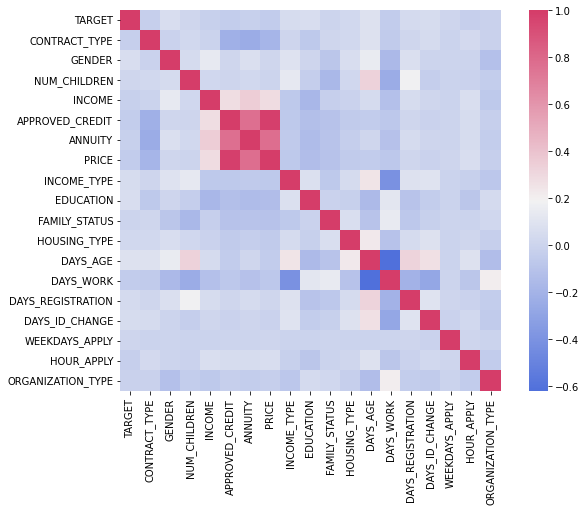

In [ ]:
plt.figure(figsize = (10,7))
corr = DATA_TRAIN.corr()
sns.heatmap(corr , mask=np.zeros_like(corr, dtype=np.bool) , cmap=sns.diverging_palette(-100,0,as_cmap=True) , square = True)

### PLOT FEATURE SELECTED

note : from the process that has been done before, i took 5 feature + made 3 feature engineering to get into the model and i did some feature engineering for "DAYS_AGE" feature that has low correlated data.

#### TARGET

In [ ]:
print('unique value :',DATA_TRAIN['TARGET'].unique())
print('counted value :\n', DATA_TRAIN['TARGET'].value_counts())
print('nan value :', DATA_TRAIN['TARGET'].isna().sum())

unique value : [0 1]
counted value :
 0    56534
1     4969
Name: TARGET, dtype: int64
nan value : 0


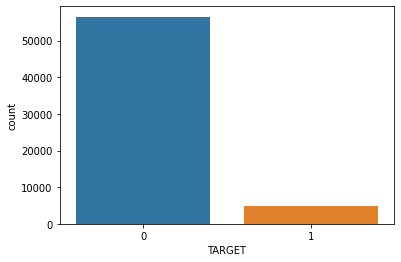

In [ ]:
# amount of target on data, (data target is imbalanced)
sns.countplot(x='TARGET', data=DATA_TRAIN)

#### APPROVED CREDIT

note : i did some feature engineering to made a distinguish between user who have approved credit less than 600k.

In [ ]:
print('maximum app credit :',DATA_TRAIN['APPROVED_CREDIT'].max())
print('minimum app credit :',DATA_TRAIN['APPROVED_CREDIT'].min())
print('mean app credit :', DATA_TRAIN['APPROVED_CREDIT'].mean())
print('nan value :', DATA_TRAIN['APPROVED_CREDIT'].isna().sum())

maximum app credit : 4050000.0
minimum app credit : 45000.0
mean app credit : 597689.917174772
nan value : 0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


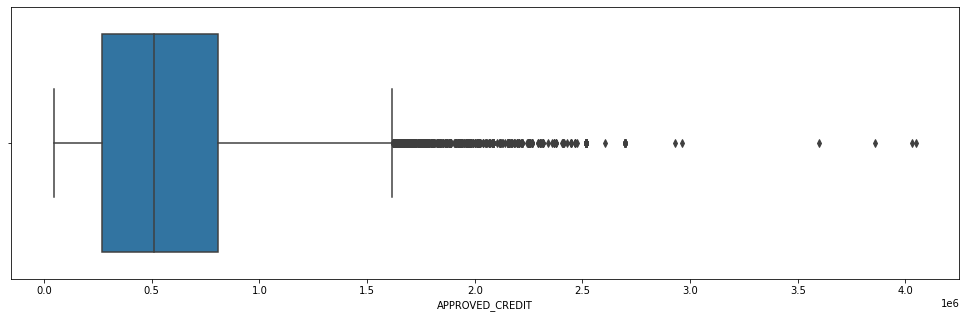

In [ ]:
# amount of approved credit loaners on data
plt.figure(figsize=(17,5))
sns.boxplot(DATA_TRAIN['APPROVED_CREDIT'])

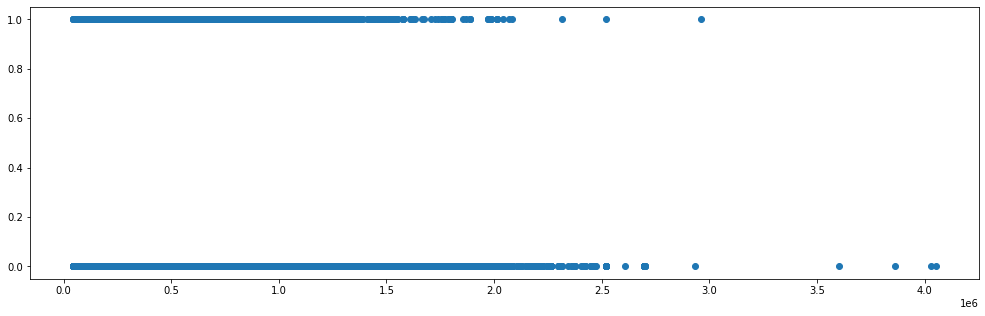

In [ ]:
# amount of approved credit loaners based on target
plt.figure(figsize=(17,5))
plt.scatter(DATA_TRAIN['APPROVED_CREDIT'], DATA_TRAIN['TARGET'])

In [ ]:
FE_AC = pd.DataFrame(columns=['is_approved_credit_less_than_600k'])
DATA_TRAIN = pd.concat([DATA_TRAIN, FE_AC])

for i in DATA_TRAIN.index:
    value = DATA_TRAIN['APPROVED_CREDIT'][i]
    if value < DATA_TRAIN['APPROVED_CREDIT'].mean() and value > DATA_TRAIN['APPROVED_CREDIT'].min():
        DATA_TRAIN['is_approved_credit_less_than_600k'][i] = 1
    else:
        DATA_TRAIN['is_approved_credit_less_than_600k'][i] = 0

DATA_TRAIN['is_approved_credit_less_than_600k'] = DATA_TRAIN['is_approved_credit_less_than_600k'].astype('int')
DATA_TRAIN.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE,is_approved_credit_less_than_600k
0,0.0,1.0,0.0,1.0,67500.0,202500.0,10125.0,202500.0,6.0,4.0,1.0,5.0,-11539.0,-921.0,-119.0,-2757.0,5.0,18.0,5.0,1
1,0.0,0.0,0.0,1.0,202500.0,976711.5,49869.0,873000.0,1.0,4.0,1.0,1.0,-15743.0,-4482.0,-1797.0,-2455.0,5.0,14.0,34.0,0
2,0.0,0.0,0.0,0.0,180000.0,407520.0,25060.5,360000.0,2.0,4.0,1.0,1.0,-20775.0,365243.0,-8737.0,-4312.0,4.0,14.0,33.0,1
3,0.0,0.0,1.0,0.0,225000.0,808650.0,26086.5,675000.0,3.0,1.0,1.0,1.0,-20659.0,-10455.0,-4998.0,-4010.0,6.0,10.0,8.0,0
4,0.0,1.0,1.0,0.0,135000.0,180000.0,9000.0,180000.0,1.0,4.0,3.0,1.0,-9013.0,-1190.0,-3524.0,-1644.0,3.0,11.0,7.0,1


#### PRICE

note : i did some feature engineering too same as approved credit because this feature was correlating with approved credit.

In [ ]:
print('maximum price :',DATA_TRAIN['PRICE'].max())
print('minimum price :',DATA_TRAIN['PRICE'].min())
print('mean price :', DATA_TRAIN['PRICE'].mean())
print('nan value :', DATA_TRAIN['PRICE'].isna().sum())

maximum price : 4050000.0
minimum price : 45000.0
mean price : 536903.3198108755
nan value : 62


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


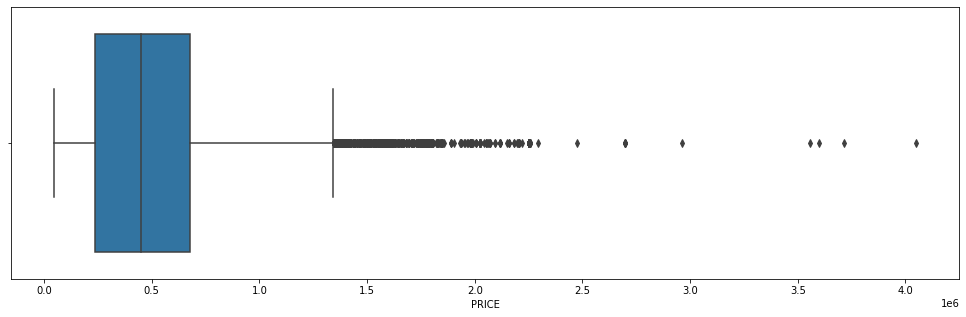

In [ ]:
# amount of price loaners on data
plt.figure(figsize=(17,5))
sns.boxplot(DATA_TRAIN['PRICE'])

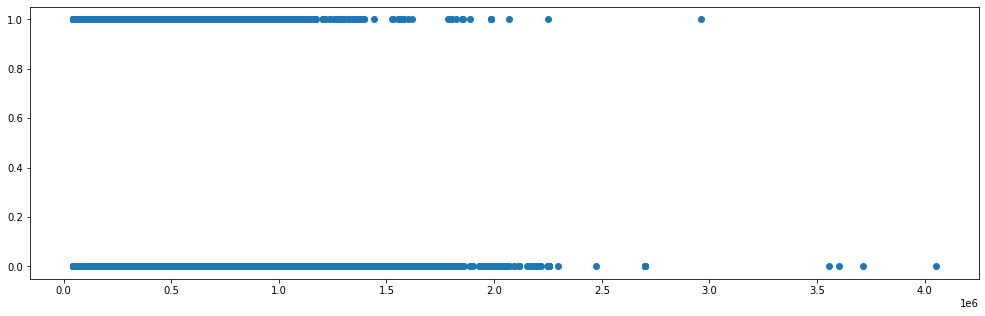

In [ ]:
# amount of price loaners based on target
plt.figure(figsize=(17,5))
plt.scatter(DATA_TRAIN['PRICE'], DATA_TRAIN['TARGET'])

In [ ]:
FE_P = pd.DataFrame(columns=['is_price_less_than_600k'])
DATA_TRAIN = pd.concat([DATA_TRAIN, FE_P])

for i in DATA_TRAIN.index:
    value = DATA_TRAIN['PRICE'][i]
    if value < DATA_TRAIN['PRICE'].mean() and value > DATA_TRAIN['PRICE'].min():
        DATA_TRAIN['is_price_less_than_600k'][i] = 1
    else:
        DATA_TRAIN['is_price_less_than_600k'][i] = 0

DATA_TRAIN['is_price_less_than_600k'] = DATA_TRAIN['is_price_less_than_600k'].astype('int')
DATA_TRAIN.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,...,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE,is_approved_credit_less_than_600k,is_price_less_than_600k
0,0.0,1.0,0.0,1.0,67500.0,202500.0,10125.0,202500.0,6.0,4.0,...,5.0,-11539.0,-921.0,-119.0,-2757.0,5.0,18.0,5.0,1.0,1
1,0.0,0.0,0.0,1.0,202500.0,976711.5,49869.0,873000.0,1.0,4.0,...,1.0,-15743.0,-4482.0,-1797.0,-2455.0,5.0,14.0,34.0,0.0,0
2,0.0,0.0,0.0,0.0,180000.0,407520.0,25060.5,360000.0,2.0,4.0,...,1.0,-20775.0,365243.0,-8737.0,-4312.0,4.0,14.0,33.0,1.0,1
3,0.0,0.0,1.0,0.0,225000.0,808650.0,26086.5,675000.0,3.0,1.0,...,1.0,-20659.0,-10455.0,-4998.0,-4010.0,6.0,10.0,8.0,0.0,0
4,0.0,1.0,1.0,0.0,135000.0,180000.0,9000.0,180000.0,1.0,4.0,...,1.0,-9013.0,-1190.0,-3524.0,-1644.0,3.0,11.0,7.0,1.0,1


#### ANNUITY

note : i did some feature engineering to made a distinguish between user who have annuity less than 27k

In [ ]:
print('maximum annuity :',DATA_TRAIN['ANNUITY'].max())
print('minimum annuity :',DATA_TRAIN['ANNUITY'].min())
print('mean annuity :', DATA_TRAIN['ANNUITY'].mean())
print('nan value :', DATA_TRAIN['ANNUITY'].isna().sum())

maximum annuity : 258025.5
minimum annuity : 2164.5
mean annuity : 27083.323314688954
nan value : 1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


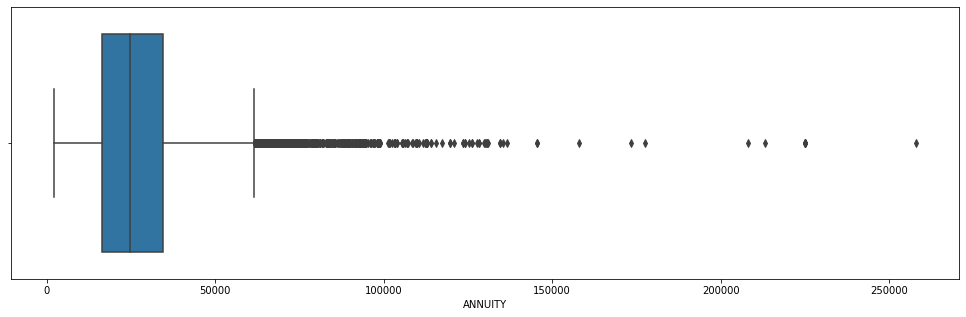

In [ ]:
# amount of annuity loaners on data
plt.figure(figsize=(17,5))
sns.boxplot(DATA_TRAIN['ANNUITY'])

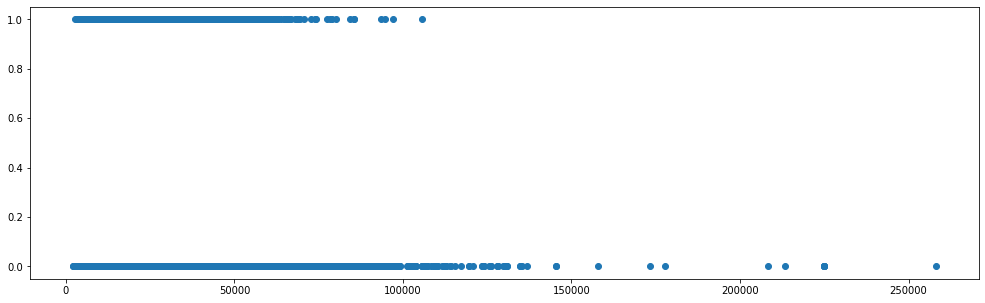

In [ ]:
# amount of annuity loaners based on target
plt.figure(figsize=(17,5))
plt.scatter(DATA_TRAIN['ANNUITY'], DATA_TRAIN['TARGET'])

In [ ]:
FE_AN = pd.DataFrame(columns=['is_annuity_less_than_27k'])
DATA_TRAIN = pd.concat([DATA_TRAIN, FE_AN])

for i in DATA_TRAIN.index:
    value = DATA_TRAIN['ANNUITY'][i]
    if value < DATA_TRAIN['ANNUITY'].mean() and value > DATA_TRAIN['ANNUITY'].min():
        DATA_TRAIN['is_annuity_less_than_27k'][i] = 1
    else:
        DATA_TRAIN['is_annuity_less_than_27k'][i] = 0

DATA_TRAIN['is_annuity_less_than_27k'] = DATA_TRAIN['is_annuity_less_than_27k'].astype('int')
DATA_TRAIN.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,...,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE,is_approved_credit_less_than_600k,is_price_less_than_600k,is_annuity_less_than_27k
0,0.0,1.0,0.0,1.0,67500.0,202500.0,10125.0,202500.0,6.0,4.0,...,-11539.0,-921.0,-119.0,-2757.0,5.0,18.0,5.0,1.0,1.0,1
1,0.0,0.0,0.0,1.0,202500.0,976711.5,49869.0,873000.0,1.0,4.0,...,-15743.0,-4482.0,-1797.0,-2455.0,5.0,14.0,34.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,180000.0,407520.0,25060.5,360000.0,2.0,4.0,...,-20775.0,365243.0,-8737.0,-4312.0,4.0,14.0,33.0,1.0,1.0,1
3,0.0,0.0,1.0,0.0,225000.0,808650.0,26086.5,675000.0,3.0,1.0,...,-20659.0,-10455.0,-4998.0,-4010.0,6.0,10.0,8.0,0.0,0.0,1
4,0.0,1.0,1.0,0.0,135000.0,180000.0,9000.0,180000.0,1.0,4.0,...,-9013.0,-1190.0,-3524.0,-1644.0,3.0,11.0,7.0,1.0,1.0,1


#### NUM CHILDREN

In [ ]:
print('unique value :',DATA_TRAIN['NUM_CHILDREN'].unique())
print('counted value :\n', DATA_TRAIN['NUM_CHILDREN'].value_counts())
print('nan value :', DATA_TRAIN['NUM_CHILDREN'].isna().sum())

unique value : [1. 0. 2. 3. 4. 6. 5. 8. 7. 9.]
counted value :
 0.0    43295
1.0    12083
2.0     5284
3.0      731
4.0       78
5.0       25
6.0        3
7.0        2
8.0        1
9.0        1
Name: NUM_CHILDREN, dtype: int64
nan value : 0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


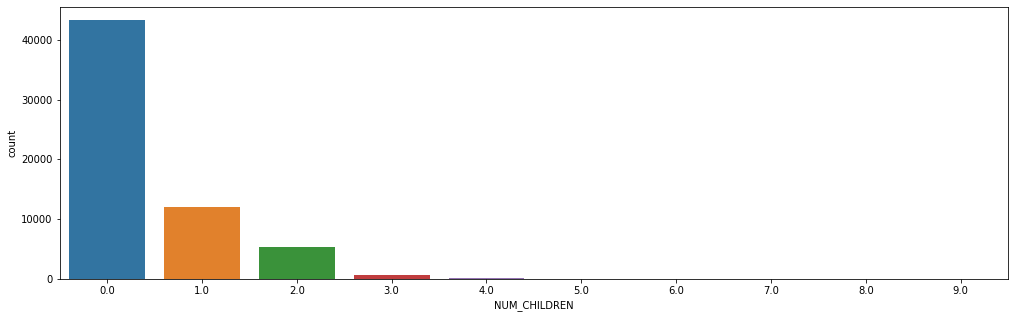

In [ ]:
# amount of income loaners on data
plt.figure(figsize=(17,5))
sns.countplot(DATA_TRAIN['NUM_CHILDREN'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


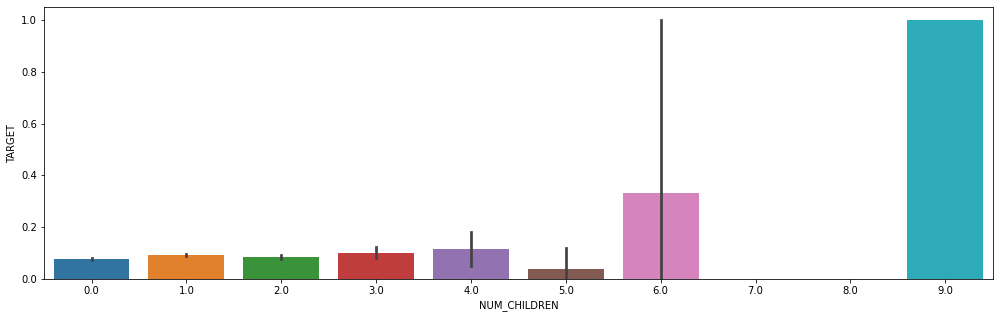

In [ ]:
# amount of income loaners based on target
plt.figure(figsize=(17,5))
sns.barplot(DATA_TRAIN['NUM_CHILDREN'], DATA_TRAIN['TARGET'])

#### DAYS AGE

note : i did a little feature engineering so it would be the age of the users

In [ ]:
DATA_TRAIN['DAYS_AGE'] = DATA_TRAIN['DAYS_AGE'].astype('int')

for i in DATA_TRAIN.index:
  DATA_TRAIN['DAYS_AGE'][i] =  DATA_TRAIN['DAYS_AGE'][i] /-365

DATA_TRAIN['DAYS_AGE']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0        31
1        43
2        56
3        56
4        24
         ..
61498    39
61499    59
61500    48
61501    30
61502    67
Name: DAYS_AGE, Length: 61503, dtype: int64

In [ ]:
print('maximum days age :',DATA_TRAIN['DAYS_AGE'].max())
print('minimum days age :',DATA_TRAIN['DAYS_AGE'].min())
print('nan value :', DATA_TRAIN['DAYS_AGE'].isna().sum())

maximum days age : 69
minimum days age : 21
nan value : 0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


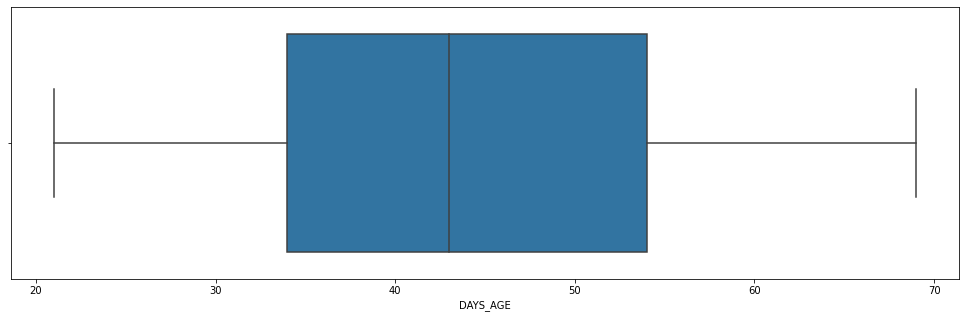

In [ ]:
# amount of income loaners on data
plt.figure(figsize=(17,5))
sns.boxplot(DATA_TRAIN['DAYS_AGE'])

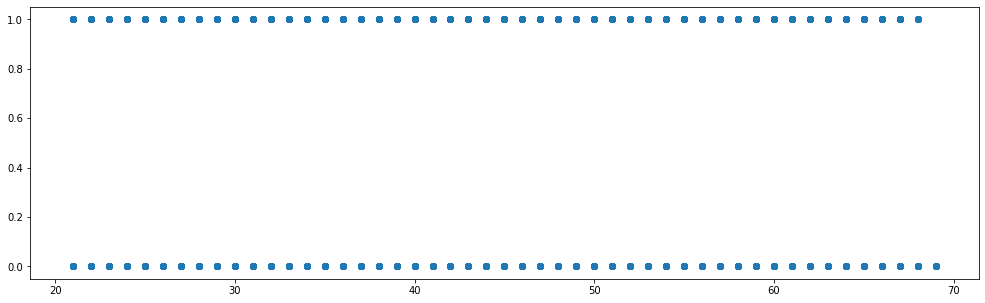

In [ ]:
# amount of income loaners based on target
plt.figure(figsize=(17,5))
plt.scatter(DATA_TRAIN['DAYS_AGE'], DATA_TRAIN['TARGET'])

## Preprocessing

Preprocess Explanation : 
1. the train data contain 8 feature that have been explored before, i.e. "APPROVED CREDIT", "PRICE", "ANNUITY", "NUM_CHILDREN", "DAYS_AGE", etc.
2. There is a nan value in "PRICE" feature, so i filled the nan value with the mean value of the feature. The reason i chose to fill it is to avoid the outlier from the feature and i did the same thing to "ANNUITY" feature.
3. After checking the target label, i found an imbalance data in target label. So, i did an oversampling methods using smote to balanced the target label. why i chose the oversampling methods, because if i try to undersampling the target label, the model cannot produce the good predict, seeing the target "1" is measly.
4. The data is scaled to far, so i normalize the data using MinMax scaling, min max scaling method normalized the scaled of data in the range from 0 to 1.
5. Last step of preprocessing the data is to split the data into train and test, i splitted the data train to 80% and data test to 20%, i guess it's a normal train test split method for every machine learning model.

In [ ]:
DATA_TRAIN.tail()

,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,...,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE,is_approved_credit_less_than_600k,is_price_less_than_600k,is_annuity_less_than_27k
61498,0.0,0.0,1.0,2.0,360000.0,450000.0,44509.5,450000.0,3.0,4.0,...,39,-5813.0,-2313.0,-2709.0,0.0,6.0,9.0,1.0,1.0,0
61499,1.0,0.0,0.0,0.0,441000.0,904500.0,38452.5,904500.0,2.0,4.0,...,59,365243.0,-4106.0,-4191.0,5.0,12.0,33.0,0.0,0.0,0
61500,0.0,1.0,0.0,0.0,202500.0,900000.0,45000.0,900000.0,1.0,1.0,...,48,-1564.0,-11844.0,-1263.0,0.0,16.0,17.0,0.0,0.0,0
61501,0.0,0.0,0.0,0.0,94500.0,360000.0,17509.5,360000.0,6.0,4.0,...,30,-4159.0,-5060.0,-3698.0,0.0,15.0,5.0,1.0,1.0,1
61502,0.0,0.0,0.0,0.0,90000.0,203760.0,20281.5,180000.0,2.0,4.0,...,67,365243.0,-12794.0,-4105.0,5.0,11.0,33.0,1.0,1.0,1


In [ ]:
train_data = DATA_TRAIN[['APPROVED_CREDIT','PRICE','ANNUITY','NUM_CHILDREN','DAYS_AGE','is_approved_credit_less_than_600k','is_price_less_than_600k', 'is_annuity_less_than_27k']]
train_target = DATA_TRAIN[['TARGET']]
train_data

,APPROVED_CREDIT,PRICE,ANNUITY,NUM_CHILDREN,DAYS_AGE,is_approved_credit_less_than_600k,is_price_less_than_600k,is_annuity_less_than_27k
0,202500.0,202500.0,10125.0,1.0,31,1.0,1.0,1
1,976711.5,873000.0,49869.0,1.0,43,0.0,0.0,0
2,407520.0,360000.0,25060.5,0.0,56,1.0,1.0,1
3,808650.0,675000.0,26086.5,0.0,56,0.0,0.0,1
4,180000.0,180000.0,9000.0,0.0,24,1.0,1.0,1
...,...,...,...,...,...,...,...,...
61498,450000.0,450000.0,44509.5,2.0,39,1.0,1.0,0
61499,904500.0,904500.0,38452.5,0.0,59,0.0,0.0,0
61500,900000.0,900000.0,45000.0,0.0,48,0.0,0.0,0
61501,360000.0,360000.0,17509.5,0.0,30,1.0,1.0,1


In [ ]:
train_data.isna().sum()

APPROVED_CREDIT                       0
PRICE                                62
ANNUITY                               1
NUM_CHILDREN                          0
DAYS_AGE                              0
is_approved_credit_less_than_600k     0
is_price_less_than_600k               0
is_annuity_less_than_27k              0
dtype: int64

In [ ]:
# fillna with mean
mean_price = train_data['PRICE'].mean()
train_data['PRICE'] = train_data['PRICE'].fillna(value=mean_price)
print('nan value :',train_data['PRICE'].isna().sum())

nan value : 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# fillna with min
mean_annuity = train_data['ANNUITY'].mean()
train_data['ANNUITY'] = train_data['ANNUITY'].fillna(value=mean_annuity)
print('nan value :',train_data['ANNUITY'].isna().sum())

nan value : 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
smt = SMOTE()
X_resamp, y_resamp = smt.fit_resample(train_data, train_target)
X_resamp

,APPROVED_CREDIT,PRICE,ANNUITY,NUM_CHILDREN,DAYS_AGE,is_approved_credit_less_than_600k,is_price_less_than_600k,is_annuity_less_than_27k
0,202500.0,202500.0,10125.0,1.000000,31,1.0,1.0,1
1,976711.5,873000.0,49869.0,1.000000,43,0.0,0.0,0
2,407520.0,360000.0,25060.5,0.000000,56,1.0,1.0,1
3,808650.0,675000.0,26086.5,0.000000,56,0.0,0.0,1
4,180000.0,180000.0,9000.0,0.000000,24,1.0,1.0,1
...,...,...,...,...,...,...,...,...
113063,337500.0,337500.0,16875.0,2.814749,28,1.0,1.0,1
113064,180000.0,180000.0,9000.0,0.000000,47,1.0,1.0,1
113065,450000.0,450000.0,21888.0,1.667293,29,1.0,1.0,1
113066,254700.0,225000.0,14751.0,0.000000,63,1.0,1.0,1


In [ ]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(X_resamp)
train_scaled

array([[0.03932584, 0.03932584, 0.0311126 , ..., 1.        , 1.        ,
        1.        ],
       [0.23263708, 0.20674157, 0.18644694, ..., 0.        , 0.        ,
        0.        ],
       [0.09051685, 0.07865169, 0.08948609, ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.1011236 , 0.1011236 , 0.07708678, ..., 1.        , 1.        ,
        1.        ],
       [0.05235955, 0.04494382, 0.04919273, ..., 1.        , 1.        ,
        1.        ],
       [0.1011236 , 0.1011236 , 0.13101059, ..., 1.        , 1.        ,
        0.        ]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_scaled, y_resamp, test_size=0.2, stratify = y_resamp)
X_train

array([[0.25797753, 0.21348315, 0.11525203, ..., 0.        , 0.        ,
        0.        ],
       [0.19067416, 0.15730337, 0.09400612, ..., 0.        , 0.        ,
        1.        ],
       [0.11298876, 0.1011236 , 0.2007479 , ..., 1.        , 1.        ,
        0.        ],
       ...,
       [0.02013483, 0.01123596, 0.01952387, ..., 1.        , 1.        ,
        1.        ],
       [0.04494382, 0.04494382, 0.05622417, ..., 1.        , 1.        ,
        1.        ],
       [0.14044944, 0.14044944, 0.0687837 , ..., 0.        , 0.        ,
        1.        ]])

## Modelling and Evaluation

Modelling Explanation :

1. I try a several model i.e. knearest neighbors, logistic regression, decision tree, random forest and support vector machine. Some of the models that already mentioned is overfitting although its not too far and i guess the random forest is a good one, the reason behind a good performance of random forest is the model can works well even though there is an uncorrelated data. Earlier at preprocess stage, i chose 2 feature that has low correlated data and did some feature engineering to one of them, this proved that the random forest can took the low correlated data and make a better prediction than other models.
2. To evaluate the models, i chose a classification report from sklearn library that include a precision, recall and f1 score along the plot of confusion matrix. Precision, recall, and f1 score is usually used for a classification method, where precision is used to measured the positive predictive value, recall is used to measured a sensitivity in classification task and f1 score is measured the accuracy of models.

### K Nearest Neighbors

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred_train_knn = knn.predict(X_train)
y_pred_train_knn

y_pred_test_knn = knn.predict(X_test)
y_pred_test_knn

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


array([0., 1., 0., ..., 0., 0., 0.])

In [ ]:
score_train_knn = classification_report(y_train, y_pred_train_knn)
print('Train k neighbors result :\n',score_train_knn)

score_test_knn = classification_report(y_test, y_pred_test_knn)
print('Test k neighbors result :\n',score_test_knn)

Train k neighbors result :
               precision    recall  f1-score   support

         0.0       0.81      0.83      0.82     45227
         1.0       0.83      0.81      0.82     45227

    accuracy                           0.82     90454
   macro avg       0.82      0.82      0.82     90454
weighted avg       0.82      0.82      0.82     90454

Test k neighbors result :
               precision    recall  f1-score   support

         0.0       0.73      0.74      0.73     11307
         1.0       0.74      0.73      0.73     11307

    accuracy                           0.73     22614
   macro avg       0.73      0.73      0.73     22614
weighted avg       0.73      0.73      0.73     22614



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


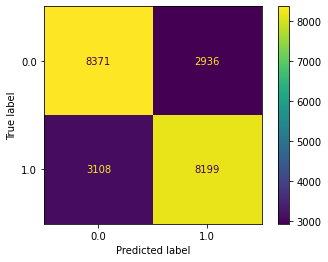

In [ ]:
plot_confusion_matrix(knn, X_test, y_test)  
plt.show()

### Logistic Regression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_train_lr = lr.predict(X_train)
y_pred_train_lr

y_pred_test_lr = lr.predict(X_test)
y_pred_test_lr

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1., 0., 1., ..., 1., 0., 0.])

In [ ]:
score_train_lr = classification_report(y_train, y_pred_train_lr)
print('Train logistic regression result :\n',score_train_lr)

score_test_lr = classification_report(y_test, y_pred_test_lr)
print('Test logistic regression result :\n',score_test_lr)

Train logistic regression result :
               precision    recall  f1-score   support

         0.0       0.60      0.58      0.59     45227
         1.0       0.59      0.62      0.61     45227

    accuracy                           0.60     90454
   macro avg       0.60      0.60      0.60     90454
weighted avg       0.60      0.60      0.60     90454

Test logistic regression result :
               precision    recall  f1-score   support

         0.0       0.60      0.58      0.59     11307
         1.0       0.59      0.62      0.60     11307

    accuracy                           0.60     22614
   macro avg       0.60      0.60      0.60     22614
weighted avg       0.60      0.60      0.60     22614



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


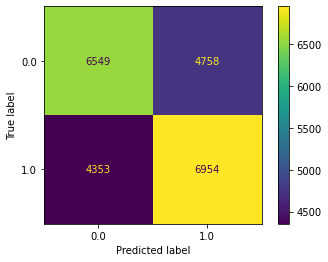

In [ ]:
plot_confusion_matrix(lr, X_test, y_test)  
plt.show()

### Decision Tree

In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

y_pred_train_dtc = dtc.predict(X_train)
y_pred_train_dtc

y_pred_test_dtc = dtc.predict(X_test)
y_pred_test_dtc

array([0., 1., 1., ..., 1., 0., 0.])

In [ ]:
score_train_dtc = classification_report(y_train, y_pred_train_dtc)
print('Train decision tree result :\n',score_train_dtc)

score_test_dtc = classification_report(y_test, y_pred_test_dtc)
print('Test decision tree result :\n',score_test_dtc)

Train decision tree result :
               precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     45227
         1.0       0.97      0.96      0.97     45227

    accuracy                           0.97     90454
   macro avg       0.97      0.97      0.97     90454
weighted avg       0.97      0.97      0.97     90454

Test decision tree result :
               precision    recall  f1-score   support

         0.0       0.84      0.83      0.83     11307
         1.0       0.83      0.84      0.84     11307

    accuracy                           0.83     22614
   macro avg       0.83      0.83      0.83     22614
weighted avg       0.83      0.83      0.83     22614



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


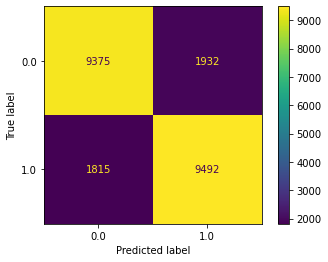

In [ ]:
plot_confusion_matrix(dtc, X_test, y_test)  
plt.show()

### Random Forest

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

y_pred_train_rfc = rfc.predict(X_train)
y_pred_train_rfc

y_pred_test_rfc = rfc.predict(X_test)
y_pred_test_rfc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


array([0., 1., 0., ..., 1., 0., 1.])

In [ ]:
score_train_rfc = classification_report(y_train, y_pred_train_rfc)
print('Train random forest result :\n',score_train_rfc)

score_test_rfc = classification_report(y_test, y_pred_test_rfc)
print('Test random forest result :\n',score_test_rfc)

Train random forest result :
               precision    recall  f1-score   support

         0.0       0.97      0.96      0.97     45227
         1.0       0.96      0.97      0.97     45227

    accuracy                           0.97     90454
   macro avg       0.97      0.97      0.97     90454
weighted avg       0.97      0.97      0.97     90454

Test random forest result :
               precision    recall  f1-score   support

         0.0       0.86      0.87      0.87     11307
         1.0       0.87      0.86      0.86     11307

    accuracy                           0.86     22614
   macro avg       0.87      0.86      0.86     22614
weighted avg       0.87      0.86      0.86     22614



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


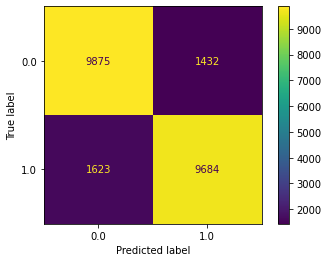

In [ ]:
plot_confusion_matrix(rfc, X_test, y_test)  
plt.show()

### Support Vector Machine

In [ ]:
svc = SVC()
svc.fit(X_train, y_train)

y_pred_train_svc = svc.predict(X_train)
y_pred_train_svc

y_pred_test_svc = svc.predict(X_test)
y_pred_test_svc

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1., 0., 1., ..., 1., 0., 1.])

In [ ]:
score_train_svc = classification_report(y_train, y_pred_train_svc)
print('Train svm result :\n',score_train_svc)

score_test_svc = classification_report(y_test, y_pred_test_svc)
print('Test svm result :\n',score_test_svc)

Train svm result :
               precision    recall  f1-score   support

         0.0       0.63      0.52      0.57     45227
         1.0       0.59      0.70      0.64     45227

    accuracy                           0.61     90454
   macro avg       0.61      0.61      0.61     90454
weighted avg       0.61      0.61      0.61     90454

Test svm result :
               precision    recall  f1-score   support

         0.0       0.64      0.53      0.58     11307
         1.0       0.60      0.70      0.64     11307

    accuracy                           0.61     22614
   macro avg       0.62      0.61      0.61     22614
weighted avg       0.62      0.61      0.61     22614



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


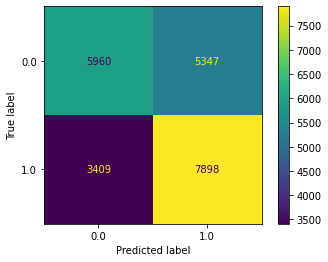

In [ ]:
plot_confusion_matrix(svc, X_test, y_test)  
plt.show()